Data exploration for my Capstone Project, a part of the Springboard Machine Learning Track.
In this project, I'm attempting to build a complete end to end traffic light detection and recognition system, using the LISA Traffic Light dataset. This notebook shows some of my exploration around the dataset. I've forked the very useful [notebook](https://www.kaggle.com/mbornoe/visualization-of-lisa-traffic-light-dataset) from [mbornoe](https://www.kaggle.com/mbornoe), and then added some extra exploratory steps.

In [26]:
# Import dependencies
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cv2
import random
import os
import numpy as np
import pandas as pd
import matplotlib.patches as patches


# Sample DayClip6
I'm going to explore the DayClip6 sample clip - but the approach can be applied with the other examples.


The following two cells chooses a random frame from the dayClip6 sample, and overlays a bounding box over the traffic lights in the scene, using the annotations provided. The bounding box will be coloured with respect to the state of the traffic light.
I've shown the image before and after the addition of the bounding boxes.

In [27]:
anno_path_box = "../input/sample-dayClip6/sample-dayClip6/frameAnnotationsBOX.csv"
anno_path_bulb = "../input/sample-dayClip6/sample-dayClip6/frameAnnotationsBULB.csv"
frames_path = "../input/sample-dayClip6/sample-dayClip6/frames/"
print("Choosing random image...")
frame_id = random.choice(os.listdir(frames_path))
# frame_id = 'dayClip6--00099.jpg'  
frame_path = os.path.join(os.path.join(frames_path,frame_id))
print("Using image:\t'{}'\nLocation:\t'{}'".format(frame_id, frame_path))
# To draw a box around the traffic light bulb, use 'anno_path_bulb' below, instead of 'anno_path_box'
annotations = []
with open(anno_path_box) as fp:  
    line = fp.readline()
    line = fp.readline() # Skip header line with descriptions
    #cnt = 1
    while line:
        anno_file_path = (line.strip()).split(";")
        anno_file_id = anno_file_path[0].split("/")[1]
        if anno_file_id == frame_id:
            annotations.append(anno_file_path)
            #print("\t{}".format(anno_file_id))
        line = fp.readline()

Choosing random image...
Using image:	'dayClip6--00223.jpg'
Location:	'../input/sample-dayClip6/sample-dayClip6/frames/dayClip6--00223.jpg'


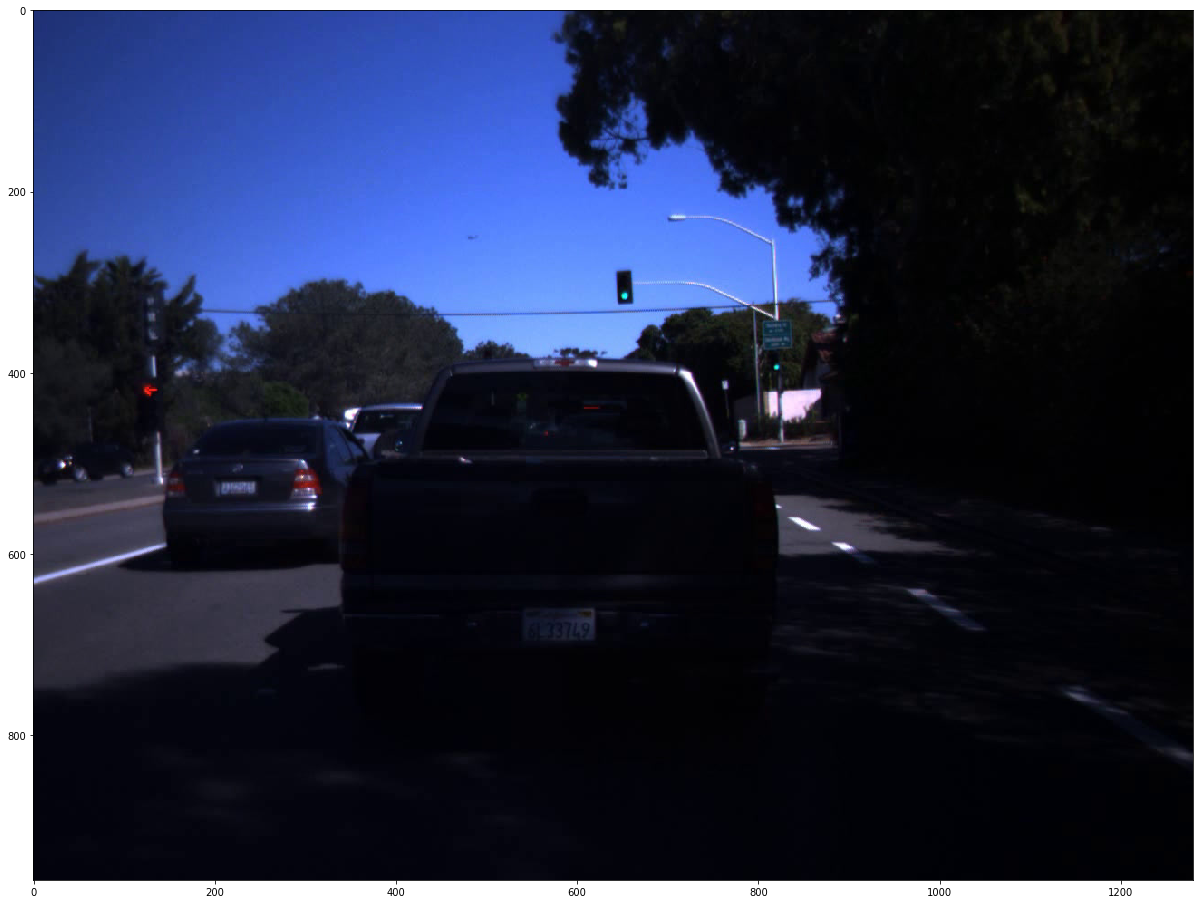

Found 3 annotations:
	Class: 'go' at [644,291,662,321]
	Class: 'go' at [814,373,826,398]
	Class: 'stopLeft' at [103,404,154,471]


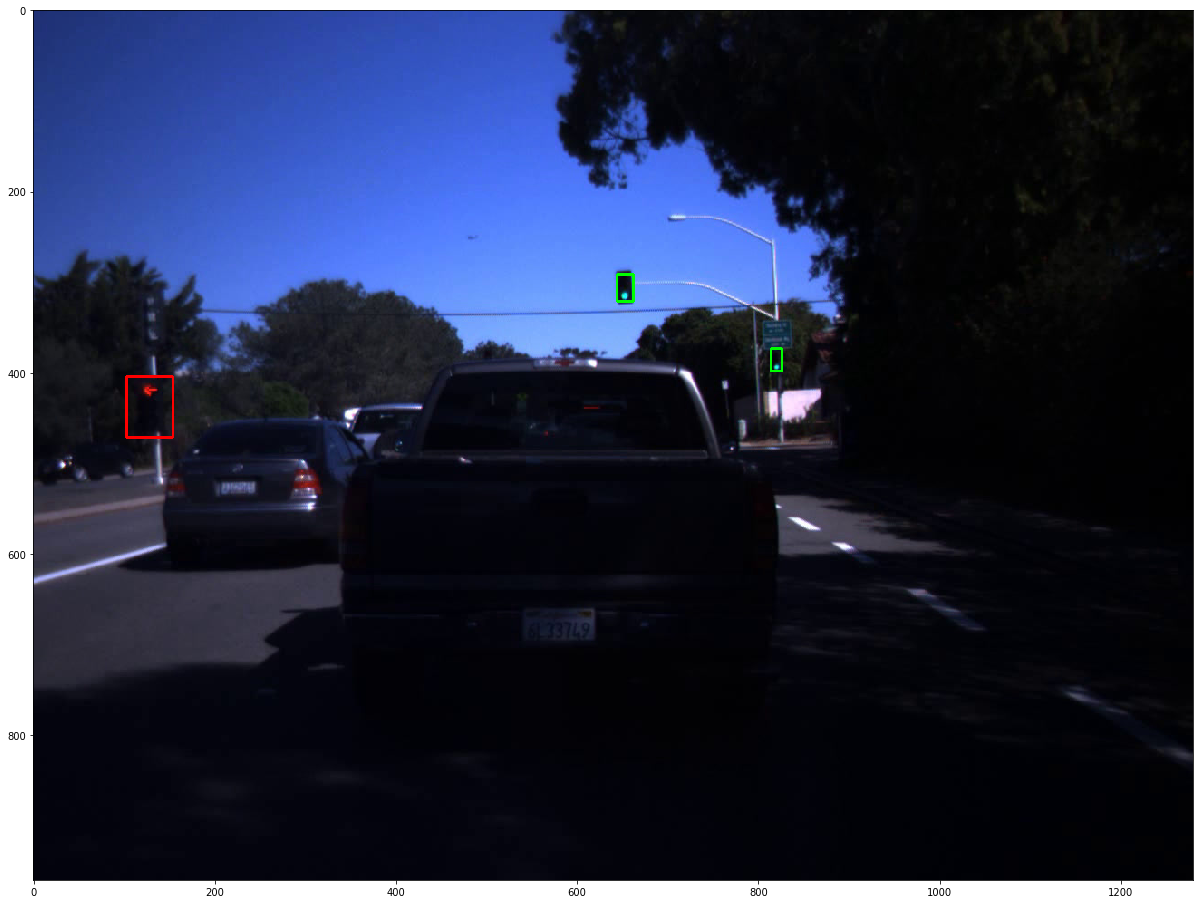

In [28]:
# Plot annotations on image
color_space = [(0,255,0),(255,0,0),(255,0,0)]
img = cv2.imread(frame_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [32, 16]
plt.imshow(img)
plt.show()
print("Found {} annotations:".format(len(annotations)))

for anno in annotations:
    anno_class = anno[1]
    anno_left = int(anno[2])
    anno_top = int(anno[3])
    anno_right = int(anno[4])
    anno_bot = int(anno[5])
    print("\tClass: '{}' at [{},{},{},{}]".format(anno_class, anno_left, anno_top, anno_right, anno_bot))
    if anno_class == "go" or anno_class == "goLeft" or anno_class == "goForward":
        color_class = color_space[0]
    elif anno_class == "warning" or anno_class == "warningLeft":
        color_class = (255,255,0)
    elif anno_class == "stop" or anno_class == "stopLeft":
        color_class = color_space[1]
    cv2.rectangle(img, (anno_left, anno_top), (anno_right, anno_bot), color_class, 2)

    
plt.imshow(img)
plt.show()


The annotations aren't in a great format for iterating over, so I've translated them into a Pandas dataframe below.

In [29]:
anno_data_frame = pd.read_csv(anno_path_box, ';') 
anno_data_frame.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip6--00000.jpg,stop,506,354,518,372,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,0,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,0
1,dayTraining/dayClip6--00000.jpg,stopLeft,595,423,613,454,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,0,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,0
2,dayTraining/dayClip6--00001.jpg,stop,504,352,516,370,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,1,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,1
3,dayTraining/dayClip6--00001.jpg,stopLeft,591,424,612,446,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,1,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,1
4,dayTraining/dayClip6--00002.jpg,stop,500,346,512,364,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,2,dayTraining/dayClip6/dayClip6Shutter0.000200-G...,2


Now that we've got our annotations in a nice dataframe, we can start exploring our data.

In [30]:
anno_data_frame.describe()

,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,Origin track frame number
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,547.025174,338.793403,570.483507,372.578125,195.045139,195.045139
std,289.249477,66.992464,279.669029,69.589793,113.694103,113.694103
min,0.000000,0.000000,22.000000,26.000000,0.000000,0.000000
25%,250.000000,291.000000,267.750000,320.000000,94.000000,94.000000
50%,644.000000,365.000000,662.000000,390.000000,192.000000,192.000000
75%,809.000000,400.000000,824.000000,428.000000,289.250000,289.250000
max,1249.000000,424.000000,1280.000000,486.000000,412.000000,412.000000


The first question I had was - are all the images of the same size?
Let's check:

In [31]:
def getImageSize(frame_path):
    img = cv2.imread(frame_path)
    height, width, channels = img.shape
    return [height, width]

In [32]:
imageSizes = [getImageSize(os.path.join(frames_path,frame_id)) for frame_path in os.listdir(frames_path)]
result = set(map(tuple, imageSizes))
print("Number of unique frame sizes: {}".format(len(result)))

Number of unique frame sizes: 1


Great, so all the images are the same size. My next question was - are the positions of the traffic lights evenly distributed throughout the images?  Let's plot all the bounding boxes, on an example image.

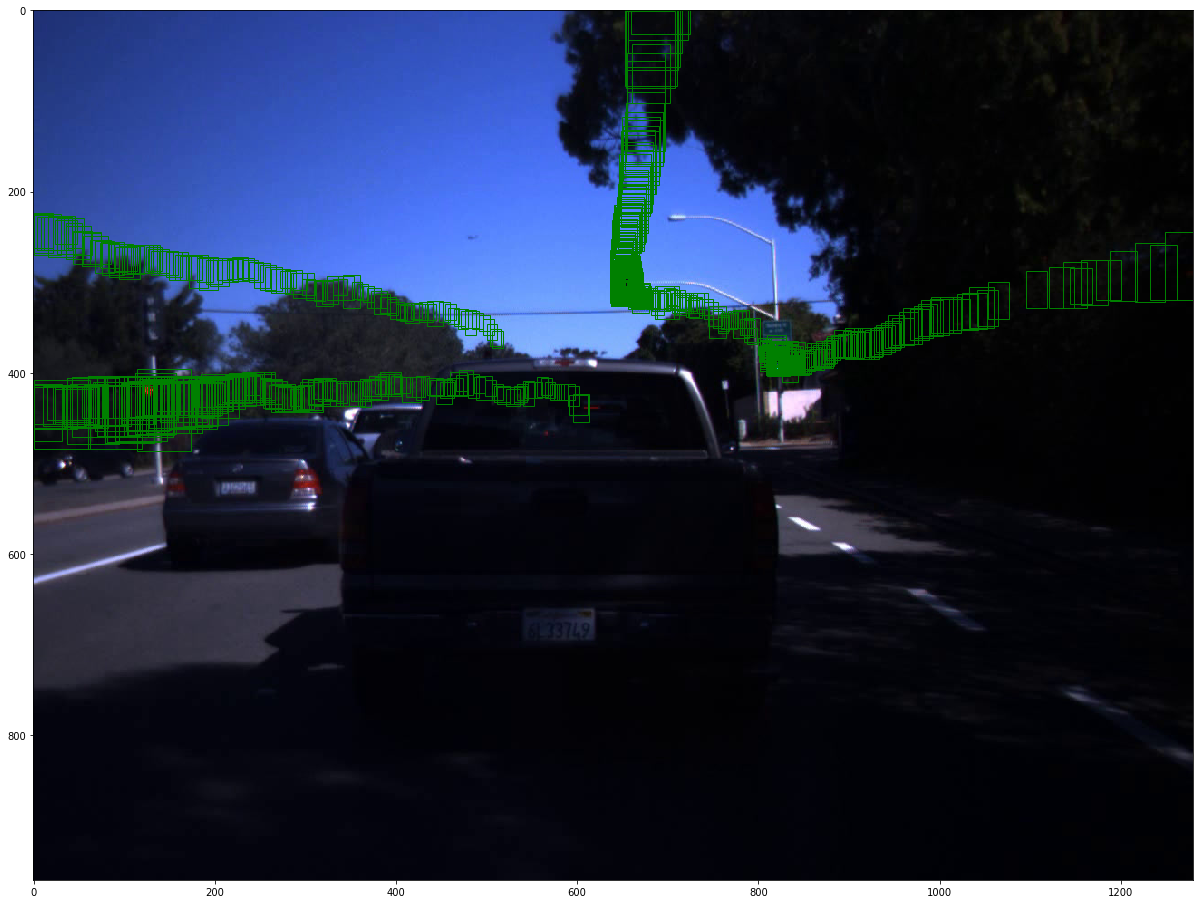

In [33]:
plt.figure(figsize=(32,16))
currentAxis = plt.gca()

for index, row in anno_data_frame.iterrows():
    width = row['Lower right corner X'] - row['Upper left corner X']
    height = row['Lower right corner Y'] - row['Upper left corner Y']
    topLeft = (row['Upper left corner X'], row['Upper left corner Y'])
    currentAxis.add_patch(patches.Rectangle(topLeft, width, height, alpha=1, fill=False, edgecolor='green'))

example_image = cv2.imread(frame_path)
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

plt.imshow(example_image)
plt.show()


The above plot is interesting, yet makes sense - The traffic lights are typically towards the top half of the image, as the camera is positioned on top of the car, which is usually below the traffic lights. 

Now, on to the annotation tags. Is there an even distribution of tags?

In [52]:
anno_data_frame['Annotation tag'].value_counts()

go          426
stop        412
stopLeft    314
Name: Annotation tag, dtype: int64

Cool - a similar number of go, stop, and stopLeft. We'll need to be careful if we use a ML technique where the number of training examples has to be equal across different classes.

I'm concerned there isn't any amber states? Let's check another sequence.

In [56]:
anno_path_box2 = "../input/Annotations/Annotations/daySequence1/frameAnnotationsBOX.csv"
frames_path2 = "../input/daySequence1/daySequence1/frames/"
anno_data_frame2 = pd.read_csv(anno_path_box2, ';')
anno_data_frame2['Annotation tag'].value_counts()

go             4719
stop           2854
warning         239
warningLeft      53
stopLeft         35
Name: Annotation tag, dtype: int64

This makes more sense! The dayClip6 sample doesn't contain warning or warningLeft states. We won't be using the sample for training so this should be fine. There are considerably less xLeft states, which is guess is just due to the smaller number of traffic lights that have a left arrow.
